# 🏨 Hotel Search Assistant | Gen AI Capstone Project

## 🔍 Problem Statement and Use Case

Planning travel accommodations is time-consuming and often frustrating:
* 🔄 Users need to visit multiple hotel booking sites.
* 📅 They must manually input dates, locations, and preferences repeatedly
* 🤯 Comparing options across different platforms is inefficient and frustrating
* ❌ Natural language queries (like "Find hotels in Goa for next weekend") aren't supported by most booking sites.


## How Gen AI Solves this
This project creates an AI-powered hotel search assistant that:

1. Understands natural language - Interprets casual requests like "Find 3-star hotels in Mumbai from May 5 to May 7 for 2 adults"
2. Automates search - Programmatically constructs and executes hotel search queries
3. Summarizes results - Extracts and presents key information (prices, ratings, amenities) clearly
4. Saves time - Reduces multiple manual steps to a single conversational interaction


##  Technologies, Tools & Gen AI Capabilities Demonstrated

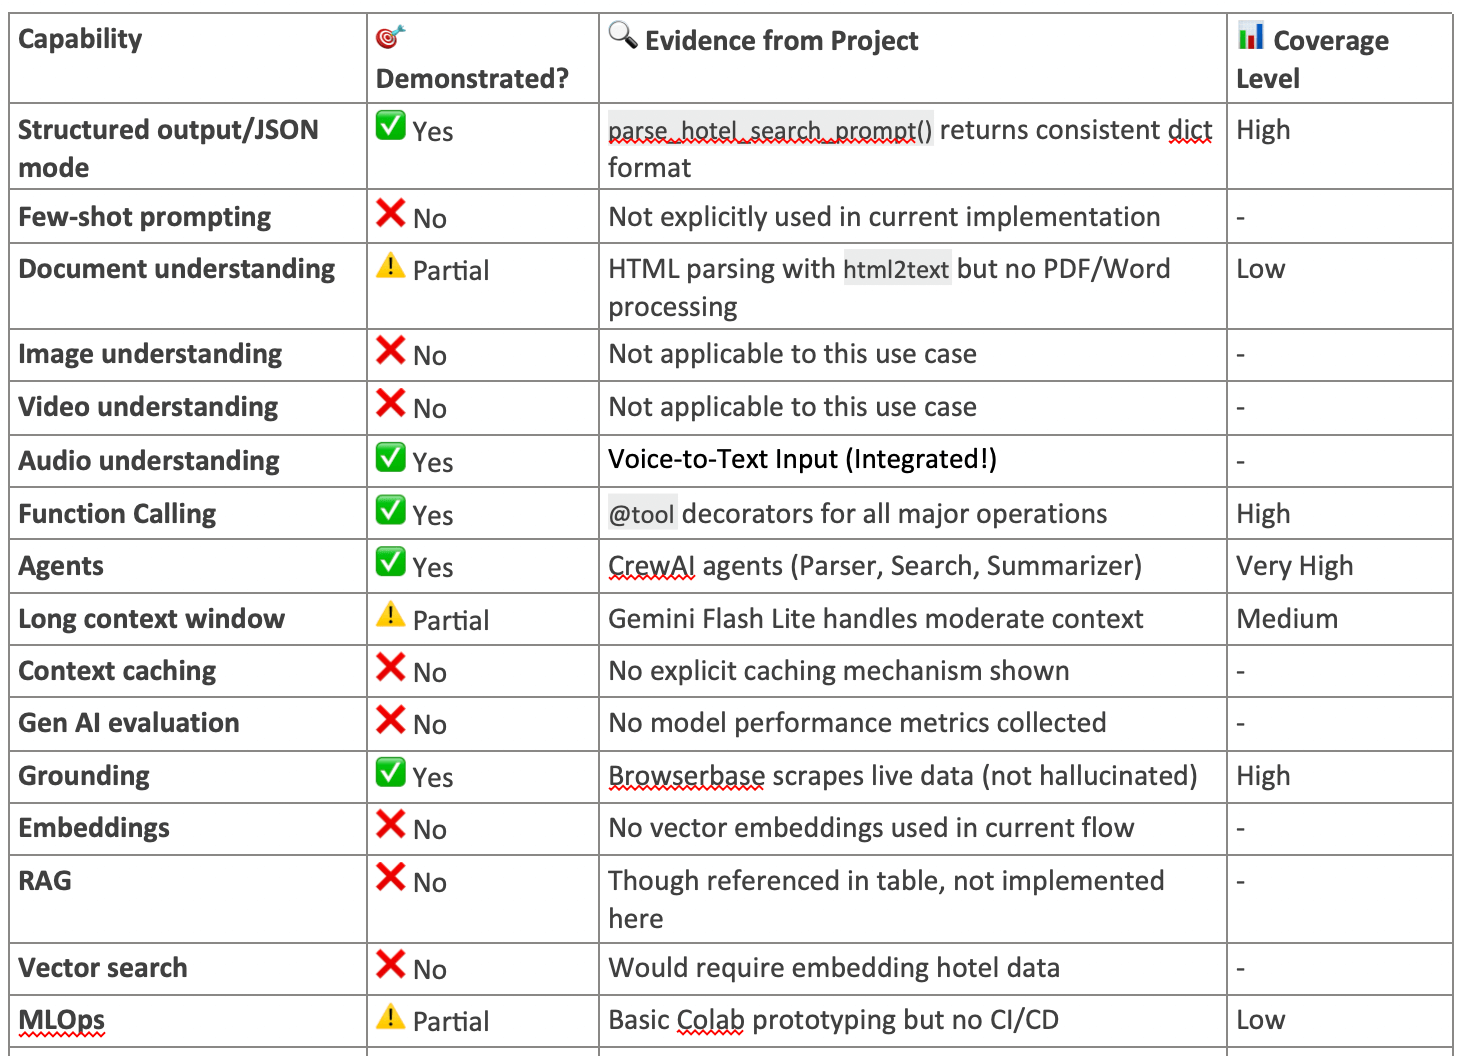

## 🧠 Gen AI Hotel Search Solution Architecture
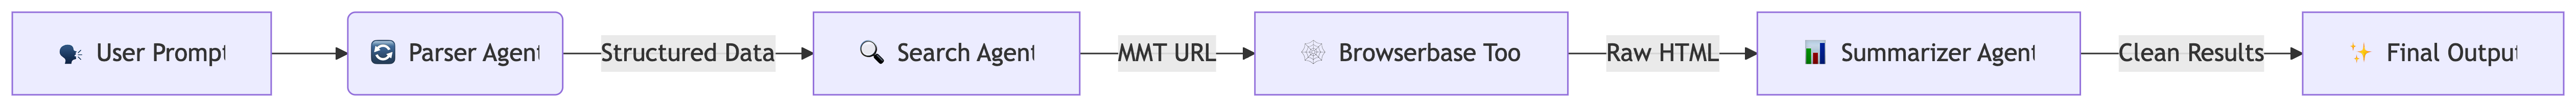

## Code Implementation with Explanation

### 1. Environment Setup

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

#### 1.1 Install Dependencies

In [2]:
!pip install crewai crewai_tools litellm -q
!pip install google-generativeai>=0.8.4 crewai[tools]>=0.100.0 --upgrade --no-deps -q
!pip install python-dotenv -q
!pip install SpeechRecognition -q
!pip install streamlit
!pip install dateparser
!pip install playwright
!pip install html2text

#### 1.2 Import Libraries

In [3]:
import os
import requests
import sys
import streamlit as st
import dateparser
from datetime import datetime
from crewai.tools import tool
from crewai_tools import BrowserbaseLoadTool
from urllib.parse import quote_plus

from crewai import Crew, Process, Task, Agent, LLM
from playwright.sync_api import sync_playwright

import html2text
from time import sleep
from dotenv import load_dotenv
from threading import Thread
from queue import Queue

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:623: UserWarning: <built-in function callable> is not a Python type (it may be an instance of an object), Pydantic will allow any object with no validation since we cannot even enforce that the input is an instance of the given type. To get rid of this error wrap the type with `pydantic.SkipValidation`.
  warn(


In [ ]:
# import sys
# sys.path.append('/kaggle/input/mmt-scraper-python-file')
# from mmt_scraper import scrape_makemytrip_page

In [ ]:
# import nest_asyncio
# import asyncio
# nest_asyncio.apply()

1.3 Import Kaggle Secrets/ API Keys

In [ ]:
# from kaggle_secrets import UserSecretsClient

# GOOGLE_API_KEY = UserSecretsClient().get_secret("GEMINI_API_KEY")
# BROWSERBASE_API_KEY = UserSecretsClient().get_secret("BROWSERBASE_API_KEY")
# BROWSERBASE_PROJECT_ID = UserSecretsClient().get_secret("BROWSERBASE_PROJECT_ID")

In [5]:
# Load Environment Variables/ API-Keys
load_dotenv("/kaggle/input/hotel-search/.env")

GOOGLE_API_KEY = os.environ['GEMINI_API_KEY']
BROWSERBASE_API_KEY = os.environ['BROWSERBASE_API_KEY']
BROWSERBASE_PROJECT_ID = os.environ['BROWSERBASE_PROJECT_ID']

In [6]:
# Check if the environment variables are loaded
print("🔑 GEMINI API:", bool(GOOGLE_API_KEY))
print("🔑 Browserbase API:", bool(BROWSERBASE_API_KEY))
print("Project ID", bool("BROWSERBASE_PROJECT_ID"))

🔑 GEMINI API: True
🔑 Browserbase API: True
Project ID True


#### 1.4 Initialize LLM (Gemini Flash Lite for fast, cost-effective responses)

In [7]:
gemini_llm = LLM(
    api_key=GOOGLE_API_KEY,
    model="gemini/gemini-2.0-flash-lite",
    temperature=0,  # Minimize creativity for factual searches
    max_tokens=None
)

### 🛠️ Key Components/Tools

1. **Browserbase_v1** Tool : Headless browser tool to scrape live hotel data from MakeMyTrip
2. **MakeMyTrip Hotel Search** Tool : Generates structured MakeMyTrip URLs from search parameters
3. **parse_hotel_search_prompt** Tool : NLP parser converting natural language to structured search terms

In [8]:
# --- Define Browserbase_v1 Tool ---


@tool("Browserbase_v1 tool")
def browserbase_v1(url: str) -> str:
    """
    Runs Playwright inside a thread to avoid asyncio loop conflicts in Jupyter/Kaggle.
    Returns hotel listing page content in plain text.
    """
    def scraper(url: str, result_queue: Queue):
        try:
            with sync_playwright() as p:
                browser = p.chromium.connect_over_cdp(
                    "wss://connect.browserbase.com?apiKey="
                    + os.environ["BROWSERBASE_API_KEY"]
                )
                context = browser.new_context(
                    locale="en-IN",
                    extra_http_headers={
                        "Accept-Language": "en-IN",
                        "X-Geo-Override": "IN"
                    }
                )
                page = context.new_page()
        
                # Block non-.com domains
                def route_handler(route):
                    if "makemytrip.com" in route.request.url:
                        route.continue_()
                    else:
                        route.abort()
                
                page.route("**/*", route_handler)
                
                page.goto(url, wait_until="networkidle")
                page.wait_for_timeout(25000)  # Better than sleep()
        
                content = html2text.html2text(page.content())
                result_queue.put(content)  # ✅ Missing in original
                browser.close()
        except Exception as e:
            result_queue.put(f"[SCRAPER ERROR] {e}")

    q = Queue()
    t = Thread(target=scraper, args=(url, q))
    t.start()
    t.join()

    return q.get()

# @tool("Browserbase_v1 tool")
# def browserbase_v1(url: str) -> str:
#     """
#     Calls mmt_scraper.py to return hotel listings HTML from MakeMyTrip using Playwright.
#     """
#     return scrape_makemytrip_page(url)
    # """
    # Wraps async Playwright inside a sync runner to work with CrewAI.
    # """
    # import asyncio

    # async def inner():
    #     from playwright.async_api import async_playwright
    #     import html2text

    #     async with async_playwright() as p:
    #         browser = await p.chromium.launch()
    #         page = await browser.new_page()
    #         await page.goto(url,wait_until="domcontentloaded")
    #         content = await page.content()
    #         await browser.close()
    #         return html2text.html2text(content)

    # return asyncio.run(inner())  # ✅ Await manually inside sync wrapper

# --- Define MakeMyTrip Hotel Tool ---
@tool("MakeMyTrip Hotel Search Tool")
def makemytrip_hotel_search(
    location: str,
    check_in_date: str,
    check_out_date: str,
    num_adults: int = 2
) -> str:
    """
    Generates a MakeMyTrip URL for hotel searches.

    :param location: A readable location name (e.g., 'Hisar, Haryana, India')
    :param location: City Code (e.g., 'CTDEL')
    :param check_in_date: Format 'YYYY-MM-DD'
    :param check_out_date: Format 'YYYY-MM-DD'
    :param num_adults: Number of adults (default is 2)
    :return: Fully formatted MakeMyTrip hotel search URL
    """
    def format_date(d):
        return datetime.strptime(d, "%Y-%m-%d").strftime("%m%d%Y")

    formatted_checkin = format_date(check_in_date)
    formatted_checkout = format_date(check_out_date)

    # Properly encode search text for the URL
    search_text = quote_plus(location.title())  # e.g., "New Delhi" → "New+Delhi"
    print("Search Text is:",search_text)

    print(f"Generating MakeMyTrip Hotel URL for {location} from {check_in_date} to {check_out_date} for {num_adults} adults")
    # location = location.replace(" ", "-").lower()
    # return f"https://www.makemytrip.com/hotels/hotel-listing/?checkin={check_in_date}&checkout={check_out_date}&city={location}&roomStayQualifier={num_adults}e0e&locusId={location}&locusType=city"

    city_search_query = f"https://mapi.makemytrip.com/autosuggest/v5/search?cc=1&exp=4&exps=expscore5&expui=v2&hcn=1&q={search_text}&sf=true&sgr=t&language=eng&region=in&currency=INR&idContext=B2C&countryCode=IN"
    # Build final URL
    headers = {"User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/129.0.0.0 Safari/537.36"}

    resp = requests.get(city_search_query,headers=headers).json()
    for r in resp:
        if "subtext" in r:
            city_code = r['cityCode']
            break
    print("City Code is:", city_code)
    url = (
        f"https://www.makemytrip.com/hotels/hotel-listing/?"
        f"checkin={formatted_checkin}&checkout={formatted_checkout}"
        f"&locusId={city_code}&locusType=city"
        f"&city={city_code}&country=IN"
        f"&searchText={search_text}"
        f"&roomStayQualifier={num_adults}e0e"
        f"&_uCurrency=INR&reference=hotel&type=city&rsc=1e{num_adults}e0e"
        f"&forceLocale=en_IN"
    )

    print("✅ Generated MakeMyTrip URL:", url)
    return url

# --- Define Prompt Parser Tool's helper function ---
def run_parse_hotel_search_prompt(prompt: str) -> dict:
    """
    Extracts structured hotel search parameters from a natural language prompt.

    :param prompt: User-provided prompt like "Find hotels in Delhi from May 2 to May 5 for 3 adults"
    :return: A dictionary with location, check-in date, check-out date, and number of adults
    """
    import re
    from dateutil import parser as date_parser

    print(f"[DEBUG] Prompt Received by Tool: {prompt}")
    data = {"location": "", "check_in_date": "", "check_out_date": "", "num_adults": 2}
    try:
        # Extract location
        location_match = re.search(r"(?:in|at|near)\s+([A-Za-z\s,]+?)\s+(?:from|between)", prompt)
        if location_match:
            data["location"] = location_match.group(1).strip()

        # Extract dates
        date_matches = re.findall(r"(?:from|between)?\s*([A-Za-z]+\s+\d{1,2})", prompt)
        if len(date_matches) >= 2:
            today = datetime.today()
            year = today.year
            data["check_in_date"] = date_parser.parse(f"{date_matches[0]} {year}").date().isoformat()
            data["check_out_date"] = date_parser.parse(f"{date_matches[1]} {year}").date().isoformat()

        # Extract number of adults
        adults_match = re.search(r"(\d+)\s*(adult|adults|people|persons)", prompt, re.IGNORECASE)
        data["num_adults"] = int(adults_match.group(1)) if adults_match else 2

    except Exception as e:
        print(f"Error parsing prompt: {e}")

    print(f"Parsed data: {data}")
    return data

# --- Define Prompt Parser Tool ---
@tool("Prompt Parser Tool")
def parse_hotel_search_prompt(prompt: str) -> dict:
    """
    Tool version of the hotel prompt parser.
    This is used by CrewAI agents to extract structured search data.
    """
    return run_parse_hotel_search_prompt(prompt)

### 🤖 AI Agents

1. **Parser Agent	(Prompt Interpreter)**:	Extracts location, dates, and guest count from natural language queries. Uses-**parse_hotel_search_prompt** tool.
2. **Search Agent	(Hotel Search Expert)**: Generates valid MakeMyTrip search URLs based on structured parameters.Uses - **makemytrip_hotel_search** tool.
3. **Summarizer Agent	(Results Presenter)**: Scrapes and summarizes hotel listings with key details (price, rating, amenities). Uses **browserbase_v1** tool

In [10]:
# --- Define search agent ---
parser_agent = Agent(
    role="Prompt Interpreter",
    goal="Extract location, dates, and number of adults from a user's natural prompt",
    backstory="I understand user prompts and extract relevant hotel search parameters.",
    tools=[parse_hotel_search_prompt],
    allow_delegation=False,
    llm=gemini_llm,
)
# --- Define search agent ---
search_agent = Agent(
    role="Hotel Search Expert",
    goal="Find the best hotel options based on location, reviews, amenities and dates",
    backstory="I find great hotel deals using MakeMyTrip and present them with booking links.",
    tools=[makemytrip_hotel_search],
    allow_delegation=False,
    llm=gemini_llm,
)

summarize_agent = Agent(
    role="Result Presenter",
    goal="Summarize hotel details in a readable format",
    backstory="I organize and present hotel results with helpful highlights and links.",
    tools=[browserbase_v1],
    allow_delegation=False,
    llm=gemini_llm,
    # step_callback=lambda x: str(x).replace("makemytrip.global", "makemytrip.com")
)

### 📋 Tasks

1. **prompt_parsing_task** : Extracts hotel search data from user's input prompt and returns a formatted dictionary of location, check_in_date, check_out_date and number of adults. This task is assigned by **Parser Agent**
2. **search_task** : Generates a MakeMyTrip url for searching hotels based on the Structured Params provided by **makemytrip_hotel_search** tool to **Search Agent**.
3. **summarize_task** : Use the **Browserbase_v1** tool to open the generated MakeMyTrip URL and Extracts the hotel details like name, rating, price, and amenities from the page and presents it as per the provided output format 

In [11]:
# --- Define tasks ---
prompt_parsing_task = Task(
    description="Extract location, check_in_date, check_out_date, and num_adults from the user's hotel search prompt: {search_prompt}",
    expected_output="A dictionary with location, check_in_date, check_out_date, and num_adults",
    agent=parser_agent,
)

output_search_example = """
Here are our top 5 hotels in Goa for September 21-22, 2025:
1. Park Inn by Radisson Goa Candolim:
   - Rating: 4.0/5
   - Price: INR 5,164 + INR 620 taxes & fees
   - Location: Candolim
   - Amenities: Gym, Swimming Pool, Spa, Restaurant, Bar
"""

search_task = Task(
    description="Generate a hotel search URL using the parser's output: ",
    expected_output="A valid MakeMyTrip hotel to be stored as search_result_url",
    agent=search_agent,
    context=[prompt_parsing_task],
)

summarize_task = Task(
    description=(
        "Use the provided Browserbase_v1 tool to open the MakeMyTrip URL generated in the previous task. "
        "Extract the hotel name, rating, price, and amenities from the page. "
        "⚠️ Do not fabricate any hotel URLs. If a direct booking link is not found, omit it. "
        "Only summarize what is visible on the loaded page content."
    ),
    expected_output=(
        "Top 5 hotels:\n"
        "1. Taj Goa - ₹6,000/night - Pool, Spa - [Link]\n"
        "2. ...\n"
    ),
    agent=summarize_agent,
    context=[search_task],
)

## 🤖📋🛠️ Assemble The Crew

In [12]:
crew = Crew(
        agents=[parser_agent,search_agent, summarize_agent],
        tasks=[prompt_parsing_task, search_task, summarize_task],
        verbose=True,
        process=Process.sequential,
    )

In [13]:
# --- Prompt input from user ---
search_prompt = input("Enter your hotel search prompt (e.g., 'Find a hotel in Mumbai from April 20 to April 22 for 2 adults'): ")

Enter your hotel search prompt (e.g., 'Find a hotel in Mumbai from April 20 to April 22 for 2 adults'):  Find a hotel in Goa from May 20 to May 25 for 2 adults


In [14]:
if search_prompt:
    result = crew.kickoff(inputs={
    "search_prompt": search_prompt})
    print("Hotel Search Result URL:", result)
else:
    print("No input received. Please try again.")

╭──────────────────────────────────────────── Crew Execution Started ─────────────────────────────────────────────╮
│                                                                                                                 │
│  Crew Execution Started                                                                                         │
│  Name: crew                                                                                                     │
│  ID: b65aa273-ba11-4ce6-936e-51cb0e51b643                                                                       │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

🚀 Crew: crew
└── 📋 Task: e5e91fcc-bf1f-475e-b1a9-0f27d4143c37
       Status: Executing Task...

🚀 Crew: crew
└── 📋 Task: e5e91fcc-bf1f-475e-b1a9-0f27d4143c37
       Status: Executing Task...
    └── 🤖 Agent: Prompt Interpreter
            Status: In Progress

# Agent: Prompt Interpreter
## Task: Extract location, check_in_date, check_out_date, and num_adults from the user's hotel search prompt: Find a hotel in Goa from May 20 to May 25 for 2 adults


🤖 Agent: Prompt Interpreter
    Status: In Progress
└── 🧠 Thinking...

05:42:32 - LiteLLM:INFO: utils.py:2896 - 
LiteLLM completion() model= gemini-2.0-flash-lite; provider = gemini
05:42:33 - LiteLLM:INFO: utils.py:1084 - Wrapper: Completed Call, calling success_handler


🤖 Agent: Prompt Interpreter
    Status: In Progress

🤖 Agent: Prompt Interpreter
    Status: In Progress

[DEBUG] Prompt Received by Tool: Find a hotel in Goa from May 20 to May 25 for 2 adults
Parsed data: {'location': 'Goa', 'check_in_date': '2025-05-20', 'check_out_date': '2025-05-25', 'num_adults': 2}


# Agent: Prompt Interpreter
## Thought: I need to extract the location, check-in date, check-out date, and number of adults from the user's prompt. I will use the Prompt Parser Tool to extract the information.
## Using tool: Prompt Parser Tool
## Tool Input: 
"{\"prompt\": \"Find a hotel in Goa from May 20 to May 25 for 2 adults\"}"
## Tool Output: 
{'location': 'Goa', 'check_in_date': '2025-05-20', 'check_out_date': '2025-05-25', 'num_adults': 2}


🤖 Agent: Prompt Interpreter
    Status: In Progress
└── 🧠 Thinking...

05:42:33 - LiteLLM:INFO: utils.py:2896 - 
LiteLLM completion() model= gemini-2.0-flash-lite; provider = gemini
05:42:34 - LiteLLM:INFO: utils.py:1084 - Wrapper: Completed Call, calling success_handler


🤖 Agent: Prompt Interpreter
    Status: In Progress



# Agent: Prompt Interpreter
## Final Answer: 
{'location': 'Goa', 'check_in_date': '2025-05-20', 'check_out_date': '2025-05-25', 'num_adults': 2}




🚀 Crew: crew
└── 📋 Task: e5e91fcc-bf1f-475e-b1a9-0f27d4143c37
       Status: Executing Task...
    └── 🤖 Agent: Prompt Interpreter
            Status: ✅ Completed

🚀 Crew: crew
└── 📋 Task: e5e91fcc-bf1f-475e-b1a9-0f27d4143c37
       Assigned to: Prompt Interpreter
       Status: ✅ Completed
    └── 🤖 Agent: Prompt Interpreter
            Status: ✅ Completed

╭──────────────────────────────────────────────── Task Completion ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Completed                                                                                                 │
│  Name: e5e91fcc-bf1f-475e-b1a9-0f27d4143c37                                                                     │
│  Agent: Prompt Interpreter                                                                                      │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

🚀 Crew: crew
├── 📋 Task: e5e91fcc-bf1f-475e-b1a9-0f27d4143c37
│      Assigned to: Prompt Interpreter
│      Status: ✅ Completed
│   └── 🤖 Agent: Prompt Interpreter
│           Status: ✅ Completed
└── 📋 Task: 5178bdf9-e72c-4e33-b75f-9306ee768f55
       Status: Executing Task...

🚀 Crew: crew
├── 📋 Task: e5e91fcc-bf1f-475e-b1a9-0f27d4143c37
│      Assigned to: Prompt Interpreter
│      Status: ✅ Completed
│   └── 🤖 Agent: Prompt Interpreter
│           Status: ✅ Completed
└── 📋 Task: 5178bdf9-e72c-4e33-b75f-9306ee768f55
       Status: Executing Task...
    └── 🤖 Agent: Hotel Search Expert
            Status: In Progress

05:42:34 - LiteLLM:INFO: utils.py:2896 - 
LiteLLM completion() model= gemini-2.0-flash-lite; provider = gemini


# Agent: Hotel Search Expert
## Task: Generate a hotel search URL using the parser's output: 


05:42:35 - LiteLLM:INFO: utils.py:1084 - Wrapper: Completed Call, calling success_handler


🤖 Agent: Hotel Search Expert
    Status: In Progress

Search Text is: Goa
Generating MakeMyTrip Hotel URL for Goa from 2025-05-20 to 2025-05-25 for 2 adults
City Code is: CTGOI
✅ Generated MakeMyTrip URL: https://www.makemytrip.com/hotels/hotel-listing/?checkin=05202025&checkout=05252025&locusId=CTGOI&locusType=city&city=CTGOI&country=IN&searchText=Goa&roomStayQualifier=2e0e&_uCurrency=INR&reference=hotel&type=city&rsc=1e2e0e&forceLocale=en_IN


# Agent: Hotel Search Expert
## Thought: I need to generate a MakeMyTrip hotel search URL based on the provided context.
## Using tool: MakeMyTrip Hotel Search Tool
## Tool Input: 
"{\"location\": \"Goa\", \"check_in_date\": \"2025-05-20\", \"check_out_date\": \"2025-05-25\", \"num_adults\": 2}"
## Tool Output: 
https://www.makemytrip.com/hotels/hotel-listing/?checkin=05202025&checkout=05252025&locusId=CTGOI&locusType=city&city=CTGOI&country=IN&searchText=Goa&roomStayQualifier=2e0e&_uCurrency=INR&reference=hotel&type=city&rsc=1e2e0e&forceLocale=en_IN


🤖 Agent: Hotel Search Expert
    Status: In Progress
└── 🧠 Thinking...

05:42:35 - LiteLLM:INFO: utils.py:2896 - 
LiteLLM completion() model= gemini-2.0-flash-lite; provider = gemini
05:42:36 - LiteLLM:INFO: utils.py:1084 - Wrapper: Completed Call, calling success_handler


🤖 Agent: Hotel Search Expert
    Status: In Progress



# Agent: Hotel Search Expert
## Final Answer: 
https://www.makemytrip.com/hotels/hotel-listing/?checkin=05202025&checkout=05252025&locusId=CTGOI&locusType=city&city=CTGOI&country=IN&searchText=Goa&roomStayQualifier=2e0e&_uCurrency=INR&reference=hotel&type=city&rsc=1e2e0e&forceLocale=en_IN




🚀 Crew: crew
├── 📋 Task: e5e91fcc-bf1f-475e-b1a9-0f27d4143c37
│      Assigned to: Prompt Interpreter
│      Status: ✅ Completed
│   └── 🤖 Agent: Prompt Interpreter
│           Status: ✅ Completed
└── 📋 Task: 5178bdf9-e72c-4e33-b75f-9306ee768f55
       Status: Executing Task...
    └── 🤖 Agent: Hotel Search Expert
            Status: ✅ Completed

🚀 Crew: crew
├── 📋 Task: e5e91fcc-bf1f-475e-b1a9-0f27d4143c37
│      Assigned to: Prompt Interpreter
│      Status: ✅ Completed
│   └── 🤖 Agent: Prompt Interpreter
│           Status: ✅ Completed
└── 📋 Task: 5178bdf9-e72c-4e33-b75f-9306ee768f55
       Assigned to: Hotel Search Expert
       Status: ✅ Completed
    └── 🤖 Agent: Hotel Search Expert
            Status: ✅ Completed

╭──────────────────────────────────────────────── Task Completion ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Completed                                                                                                 │
│  Name: 5178bdf9-e72c-4e33-b75f-9306ee768f55                                                                     │
│  Agent: Hotel Search Expert                                                                                     │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

🚀 Crew: crew
├── 📋 Task: e5e91fcc-bf1f-475e-b1a9-0f27d4143c37
│      Assigned to: Prompt Interpreter
│      Status: ✅ Completed
│   └── 🤖 Agent: Prompt Interpreter
│           Status: ✅ Completed
├── 📋 Task: 5178bdf9-e72c-4e33-b75f-9306ee768f55
│      Assigned to: Hotel Search Expert
│      Status: ✅ Completed
│   └── 🤖 Agent: Hotel Search Expert
│           Status: ✅ Completed
└── 📋 Task: 6c4ab3ef-109f-41d2-9fab-6d0ca90b7874
       Status: Executing Task...

🚀 Crew: crew
├── 📋 Task: e5e91fcc-bf1f-475e-b1a9-0f27d4143c37
│      Assigned to: Prompt Interpreter
│      Status: ✅ Completed
│   └── 🤖 Agent: Prompt Interpreter
│           Status: ✅ Completed
├── 📋 Task: 5178bdf9-e72c-4e33-b75f-9306ee768f55
│      Assigned to: Hotel Search Expert
│      Status: ✅ Completed
│   └── 🤖 Agent: Hotel Search Expert
│           Status: ✅ Completed
└── 📋 Task: 6c4ab3ef-109f-41d2-9fab-6d0ca90b7874
       Status: Executing Task...
    └── 🤖 Agent: Result Presenter
            Status: In Progress

05:42:36 - LiteLLM:INFO: utils.py:2896 - 
LiteLLM completion() model= gemini-2.0-flash-lite; provider = gemini


# Agent: Result Presenter
## Task: Use the provided Browserbase_v1 tool to open the MakeMyTrip URL generated in the previous task. Extract the hotel name, rating, price, and amenities from the page. ⚠️ Do not fabricate any hotel URLs. If a direct booking link is not found, omit it. Only summarize what is visible on the loaded page content.


05:42:37 - LiteLLM:INFO: utils.py:1084 - Wrapper: Completed Call, calling success_handler


🤖 Agent: Result Presenter
    Status: In Progress



# Agent: Result Presenter
## Thought: I need to use the Browserbase_v1 tool to access the provided URL and extract the required information (hotel name, rating, price, and amenities) for the top 5 hotels. I will then format the extracted data as requested.
## Using tool: Browserbase_v1 tool
## Tool Input: 
"{\"url\": \"https://www.makemytrip.com/hotels/hotel-listing/?checkin=05202025&checkout=05252025&locusId=CTGOI&locusType=city&city=CTGOI&country=IN&searchText=Goa&roomStayQualifier=2e0e&_uCurrency=INR&reference=hotel&type=city&rsc=1e2e0e&forceLocale=en_IN\"}"
## Tool Output: 
![MMT's
LOGO](https://promos.makemytrip.com/Growth/Images/B2C/GCC/A2A/mmtgblblue.png)

  * [ Flights Flights ](/flights/)
  * [ Hotels Hotels ](/hotels/)

  * Login or Create Account

  * Currency

USD

CITY, AREA or PROPERTY

Check-In

Check-Out

You are booking hotel for more than 30 days

Rooms & Guests

Search

  * [Home](//www.makemytrip.global)
  * Hotels and more in Goa

# 3549 Properties in Goa

Sort B

🤖 Agent: Result Presenter
    Status: In Progress
└── 🧠 Thinking...

05:43:11 - LiteLLM:INFO: utils.py:2896 - 
LiteLLM completion() model= gemini-2.0-flash-lite; provider = gemini
05:43:13 - LiteLLM:INFO: utils.py:1084 - Wrapper: Completed Call, calling success_handler


🤖 Agent: Result Presenter
    Status: In Progress



# Agent: Result Presenter
## Final Answer: 
Top 5 hotels:
1. Ginger Goa, Candolim - $49/night - Gym, Kids Play Area, Indoor Games - [Login to Book Now & Pay Later!]
2. Magnum Resorts- Near Candolim Beach - $31/night - Restaurant, Bar, Swimming Pool - [Login to Book Now & Pay Later!]
3. Hyatt Ronil Goa - a JdV by Hyatt - $70/night - Gym, Swimming Pool, Spa - [Login to Book Now & Pay Later!]
4. ibis Styles Goa Calangute - An Accor Brand - $45/night - Gym, Kids Play Area, Indoor Games - [Login to Book Now & Pay Later!]
5. Hard Rock Hotel Goa Calangute - $73/night - Gym, Swimming Pool, Spa - [Login to Book Now & Pay Later!]




🚀 Crew: crew
├── 📋 Task: e5e91fcc-bf1f-475e-b1a9-0f27d4143c37
│      Assigned to: Prompt Interpreter
│      Status: ✅ Completed
│   └── 🤖 Agent: Prompt Interpreter
│           Status: ✅ Completed
├── 📋 Task: 5178bdf9-e72c-4e33-b75f-9306ee768f55
│      Assigned to: Hotel Search Expert
│      Status: ✅ Completed
│   └── 🤖 Agent: Hotel Search Expert
│           Status: ✅ Completed
└── 📋 Task: 6c4ab3ef-109f-41d2-9fab-6d0ca90b7874
       Status: Executing Task...
    └── 🤖 Agent: Result Presenter
            Status: ✅ Completed

🚀 Crew: crew
├── 📋 Task: e5e91fcc-bf1f-475e-b1a9-0f27d4143c37
│      Assigned to: Prompt Interpreter
│      Status: ✅ Completed
│   └── 🤖 Agent: Prompt Interpreter
│           Status: ✅ Completed
├── 📋 Task: 5178bdf9-e72c-4e33-b75f-9306ee768f55
│      Assigned to: Hotel Search Expert
│      Status: ✅ Completed
│   └── 🤖 Agent: Hotel Search Expert
│           Status: ✅ Completed
└── 📋 Task: 6c4ab3ef-109f-41d2-9fab-6d0ca90b7874
       Assigned to: Result Presenter
       Status: ✅ Completed
    └── 🤖 Agent: Result Presenter
            Status: ✅ Completed

╭──────────────────────────────────────────────── Task Completion ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Completed                                                                                                 │
│  Name: 6c4ab3ef-109f-41d2-9fab-6d0ca90b7874                                                                     │
│  Agent: Result Presenter                                                                                        │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── Crew Completion ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Crew Execution Completed                                                                                       │
│  Name: crew                                                                                                     │
│  ID: b65aa273-ba11-4ce6-936e-51cb0e51b643                                                                       │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Hotel Search Result URL: Top 5 hotels:
1. Ginger Goa, Candolim - $49/night - Gym, Kids Play Area, Indoor Games - [Login to Book Now & Pay Later!]
2. Magnum Resorts- Near Candolim Beach - $31/night - Restaurant, Bar, Swimming Pool - [Login to Book Now & Pay Later!]
3. Hyatt Ronil Goa - a JdV by Hyatt - $70/night - Gym, Swimming Pool, Spa - [Login to Book Now & Pay Later!]
4. ibis Styles Goa Calangute - An Accor Brand - $45/night - Gym, Kids Play Area, Indoor Games - [Login to Book Now & Pay Later!]
5. Hard Rock Hotel Goa Calangute - $73/night - Gym, Swimming Pool, Spa - [Login to Book Now & Pay Later!]
